In [72]:
from requests import get
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import time

import re

In [2]:
# getting the html info to be used
#url = 'https://www.hostelworld.com/s?q=Medellin,%20Colombia&city=Medellin&country=Colombia&type=city&id=661&from=2022-01-20&to=2022-01-23&guests=2&page=1'
#response = get(url)

# create soup
#soup = BeautifulSoup(response.text, 'lxml')

# creating individual containers, on each one there's information about one hostel.
#hostel_containers= soup.find(class_= 'fabresult rounded clearfix hwta-property')

In [3]:
#soup.prettify

In [4]:
# getting the html info to be used
url = 'https://www.hostelworld.com/hostels/Medellin'
response = get(url)

# create soup
soup = BeautifulSoup(response.text, 'html.parser')

# creating individual containers, on each one there's information about one hostel.
holstel_containers= soup.findAll(class_= 'fabresult rounded clearfix hwta-property')

In [5]:
response.text

'<!DOCTYPE html>\n    <!--[if IE 9]><html class="lt-ie10" lang="en" > <![endif]-->\n<html class="no-js" lang="en" >\n\n<head>\n    <meta charset="utf-8">\n    <meta name="viewport" content="width=device-width, minimum-scale=1.0, initial-scale=1.0, maximum-scale=1.0, user-scalable=no">\n    <meta name="format-detection" content="telephone=no">\n    <meta name="theme-color" content="#313131">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta content="text/html; charset=utf-8" http-equiv="Content-Type">\n\n    <title>Hostels in Medellin - Top Rated Hostels 2021 - Hostelworld</title>\n    <meta name="Description" content="Compare cheap Medellin hostels. Read 2021 reviews, search by map and get FREE cancellation. Find YOUR kind of hostel." />\n        <meta name="msvalidate.01" content="B062587789B141D9BF3FED9B67A6B3F6" />\n            \n    \n            <link rel="canonical" href="https://www.hostelworld.com/findabed.php/ChosenCity.Medellin/ChosenCountry.Colombia" />\n

In [6]:
# Figuring out how many pages with hostels do we have available. This information is important when iterating over pages.
total_pages= soup.findAll(class_= "pagination-page-number")
final_page= pd.to_numeric(total_pages[-1].text)
final_page

2

In [7]:
# checking how many hostels we have on the first page
len(holstel_containers)

30

In [8]:
holstel_containers[0].parent.parent.parent

<div class="row pagecontent">
<script id="fabFeaturedListingTemplate" type="text/template">
<li>
    <div class="featured-listing <% if (property.freeCancellationAvailable) { %>fc-available<% } %>" url="<%= property.url %>"
         id="featuredListing_<%= property.id %>" data-name="<%= property.name %>" data-id="<%= property.id %>">

        <% if (property.hw20Party.id) { %>
                <div class="show-for-medium-up cursor-pointer fabresult-featured-20-parties">
                    <span class="fabresult-featured-20-parties-ico pull-right tip-top"
                       data-tooltip data-alignment="center" aria-haspopup="true"
                       title="<%= translate(property.hw20Party.hoverText) %>">
                    </span>
                </div>
        <% } %>

        <div class="featured-listing-details">
            <h2><a href="<%= property.url %>" class="hwta-property-link"><%= property.name %></a></h2>

            <wish-list-trigger
                :property-id=

In [9]:
first_hostel = holstel_containers[0]
print(first_hostel.prettify())

<div class="fabresult rounded clearfix hwta-property" data-id="273991" data-name="Los Patios Hostel" id="searchResults_273991" url="https://www.hostelworld.com/hosteldetails.php/Los-Patios-Hostel/Medellin/273991">
 <div class="fab-carousel-skeleton carousel-skeleton">
  <div class="fab-carousel-container small-12 medium-5 large-3 columns rounded" data-images="https://a.hwstatic.com/propertyimages/2/273991/pkulqkomtftaekqrfyhs.jpg,https://a.hwstatic.com/propertyimages/2/273991/jsxbugtlokam5ig6td8s.jpg,https://a.hwstatic.com/propertyimages/2/273991/mmpity8toxme6nub7hcg.jpg,https://a.hwstatic.com/propertyimages/2/273991/u1zptgzyycr1vxnsdaht.jpg,https://a.hwstatic.com/propertyimages/2/273991/gh6rwwpzzfdocdktc0le.jpg,https://a.hwstatic.com/propertyimages/2/273991/uelhtir519wbe03k1ut5.jpg,https://a.hwstatic.com/propertyimages/2/273991/sdeldpz3uosaxefku7dl.jpg,https://a.hwstatic.com/propertyimages/2/273991/p6iyk1iawixbu8qrtfu5.jpg,https://a.hwstatic.com/propertyimages/2/273991/opvq48ywujdbgve

In [10]:
# Hostel name
first_hostel.h2.a.text

'Los Patios Hostel'

In [11]:
# hostel link
first_hostel.h2.a.get('href')

'https://www.hostelworld.com/hosteldetails.php/Los-Patios-Hostel/Medellin/273991'

In [12]:
# distance from city centre in km
first_hostel.find(class_= "addressline").text[12:18].replace('k','').replace('m','').strip()

'4.8'

In [13]:
# average rating
first_hostel.find(class_='hwta-rating-score').text.replace('\n', '').strip()

'9.5'

In [14]:
# number of reviews
first_hostel.find(class_="hwta-rating-counter").text.replace('\n', '').strip()

'2213'

In [15]:
# average price per night in US$
first_hostel.find(class_= "price").text.replace('\n', '').strip()[3:]

'11.96'

In [16]:
# first, create the empty lists
hostel_names= []
hostel_links= []
hostel_distance= []
hostel_ratings= []
hostel_reviews= []
hostel_prices= []

for page in np.arange(1,final_page+1): # to iterate over the pages and create the conteiners, using the final_page data we've got at the begining
  url = 'https://www.hostelworld.com/hostels/Medellin?page=' + str(page)
  response = get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  holstel_containers= soup.findAll(class_= 'fabresult rounded clearfix hwta-property')

  for item in range(len(holstel_containers)): # to iterate over the results on each page
    hostel_names.append(holstel_containers[item].h2.a.text)
    hostel_links.append(holstel_containers[item].h2.a.get('href'))
    hostel_distance.append(holstel_containers[item].find(class_= "addressline").text[12:18].replace('k','').replace('m','').strip())
    hostel_ratings.append(holstel_containers[item].find(class_='hwta-rating-score').text.replace('\n', '').strip())
    hostel_reviews.append(holstel_containers[item].find(class_="hwta-rating-counter").text.replace('\n', '').strip())
    hostel_prices.append(holstel_containers[item].find(class_= "price").text.replace('\n', '').strip()[3:])                          
  time.sleep(2) # this is used to not push too hard on the website

In [56]:
# using the lists to create a brand new dataframe
df_medellin = pd.DataFrame({
    'hostel_name': hostel_names,
    'distance_center_km': hostel_distance,
    'average_rating': hostel_ratings,
    'number_reviews': hostel_reviews,
    'price_usd': hostel_prices,
    'url': hostel_links
})

df_medellin.sort_values("average_rating", ascending = False)

,hostel_name,distance_center_km,average_rating,number_reviews,price_usd,url
26,Charlie Palace Hostel,4.7,9.9,5,9.74,https://www.hostelworld.com/hosteldetails.php/...
34,El Descanso Donde Sara,2.2,9.8,35,7.97,https://www.hostelworld.com/hosteldetails.php/...
30,La Cabaña Musical,11.7,9.8,6,12.46,https://www.hostelworld.com/hosteldetails.php/...
24,61Prado Guesthouse,1.5,9.8,107,10.21,https://www.hostelworld.com/hosteldetails.php/...
0,Los Patios Hostel,4.8,9.5,2213,11.96,https://www.hostelworld.com/hosteldetails.php/...
9,Medellín Vibes Hostel,5.2,9.5,177,20.28,https://www.hostelworld.com/hosteldetails.php/...
3,Purple Monkey Hostel,4.7,9.5,1346,7.22,https://www.hostelworld.com/hosteldetails.php/...
19,Gaston Coliving,2.6,9.5,40,4.98,https://www.hostelworld.com/hosteldetails.php/...
27,Secret Buddha,14.6,9.4,133,9.97,https://www.hostelworld.com/hosteldetails.php/...
6,Hostel Rango Boutique,5.3,9.4,991,10.71,https://www.hostelworld.com/hosteldetails.php/...


In [59]:
df_medellin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hostel_name         55 non-null     object
 1   distance_center_km  55 non-null     object
 2   average_rating      55 non-null     object
 3   number_reviews      55 non-null     object
 4   price_usd           55 non-null     object
 5   url                 55 non-null     object
dtypes: object(6)
memory usage: 2.7+ KB


In [61]:
#data cleaning

#remove letters from distance values
df_medellin.distance_center_km = df_medellin.distance_center_km.str.strip(' fr')
df_medellin.distance_center_km.astype('float')

#remove hostel with cost of $24,913
df_medellin = df_medellin[df_medellin.price_usd.astype('float') < 500.00]

#convert numerical columns to numerical format
list_to_convert = ['distance_center_km', 'average_rating', 'number_reviews', 'price_usd']

for column in list_to_convert:
  df_medellin[column] = pd.to_numeric(df_medellin[column], errors= 'coerce')

df_medellin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 54
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hostel_name         54 non-null     object 
 1   distance_center_km  54 non-null     float64
 2   average_rating      54 non-null     float64
 3   number_reviews      54 non-null     int64  
 4   price_usd           54 non-null     float64
 5   url                 54 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.0+ KB


/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [62]:
df_medellin

,hostel_name,distance_center_km,average_rating,number_reviews,price_usd,url
0,Los Patios Hostel,4.8,9.5,2213,11.96,https://www.hostelworld.com/hosteldetails.php/...
1,Viajero Medellin Hostel,4.8,9.3,141,14.20,https://www.hostelworld.com/hosteldetails.php/...
2,Masaya Medellin,5.2,9.2,111,13.73,https://www.hostelworld.com/hosteldetails.php/...
3,Purple Monkey Hostel,4.7,9.5,1346,7.22,https://www.hostelworld.com/hosteldetails.php/...
4,Black Sheep Hostel Medellin,5.4,9.2,2679,7.97,https://www.hostelworld.com/hosteldetails.php/...
5,La Playa Hostel & Rooftop,5.6,9.3,385,9.97,https://www.hostelworld.com/hosteldetails.php/...
6,Hostel Rango Boutique,5.3,9.4,991,10.71,https://www.hostelworld.com/hosteldetails.php/...
7,Selina Medellin,5.6,7.6,567,6.73,https://www.hostelworld.com/hosteldetails.php/...
8,The Sugar Cane Hostel,4.7,9.2,1230,7.47,https://www.hostelworld.com/hosteldetails.php/...
9,Medellín Vibes Hostel,5.2,9.5,177,20.28,https://www.hostelworld.com/hosteldetails.php/...


In [64]:
df_medellin.corr()

,distance_center_km,average_rating,number_reviews,price_usd
distance_center_km,1.000000,0.162657,0.120800,0.187883
average_rating,0.162657,1.000000,0.260098,-0.175863
number_reviews,0.120800,0.260098,1.000000,-0.135453
price_usd,0.187883,-0.175863,-0.135453,1.000000


<AxesSubplot:>

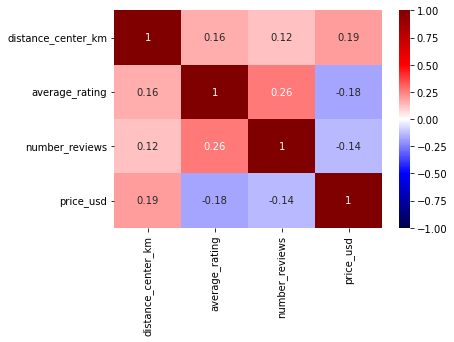

In [68]:
sns.heatmap(df_medellin.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

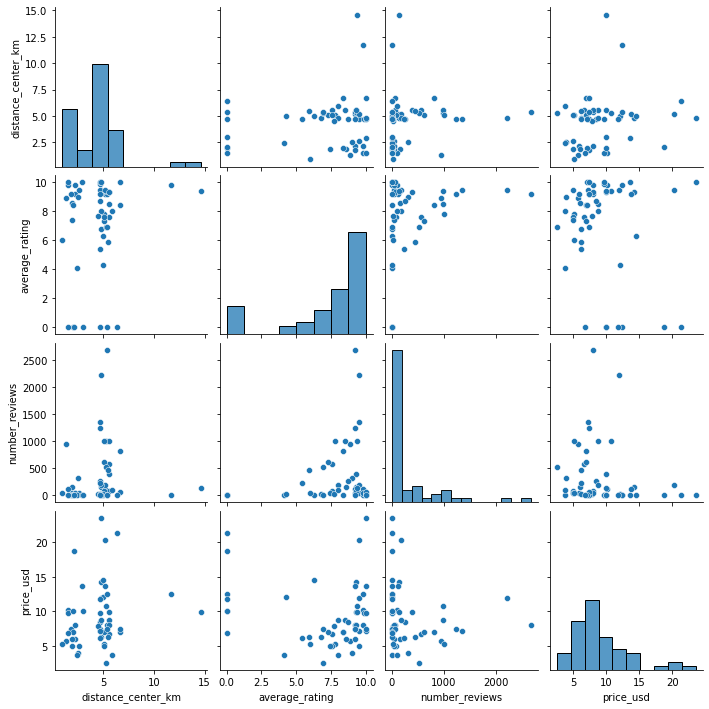

In [70]:
sns.pairplot(df_medellin)

In [75]:
#linear regression

X = df_medellin[['distance_center_km','average_rating','number_reviews']]
y = df_medellin['price_usd']
lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y)

0.09147075104222557

In [78]:
#mean squared error
preds = lr.predict(X)
rmse = mean_squared_error(y, preds, squared=False)
rmse

4.179712909327696